Intégrale de Riemann : 6.939103626372618
Intégrale de Lebesgue : 6.9400172353712755


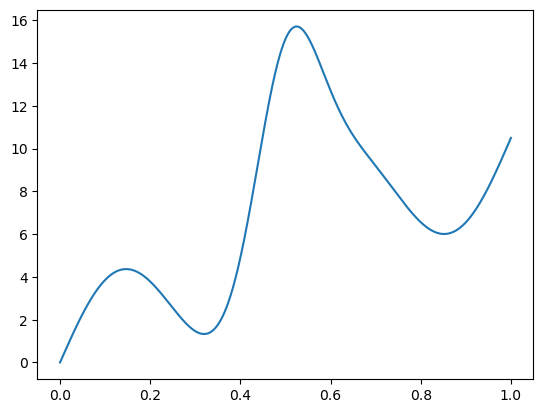

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
a, b, c = 0.5, 10, 3
Left, Right = 0, 1
N = 100000  # nombre de subdivisions pour Riemann
M = 1000    # nombre de niveaux pour Lebesgue

# Fonction à intégrer
def f(x):
    return a*x**2 + b*x + c*np.sin(4*np.pi*x) + 10*np.exp(-100*(x-0.5)**2)

# -----------------------------
# Intégrale de Riemann (somme de rectangles)
# -----------------------------
x_riemann = np.linspace(Left, Right, N)
dx = (Right - Left)/N
integral_riemann = np.sum(f(x_riemann) * dx)
print("Intégrale de Riemann :", integral_riemann)

# -----------------------------
# Intégrale de Lebesgue (approximation)
# -----------------------------
# On approxime l'intégrale comme somme sur les niveaux de f
f_min, f_max = np.min(f(x_riemann)), np.max(f(x_riemann))
levels = np.linspace(f_min, f_max, M)
dy = (f_max - f_min)/M

integral_lebesgue = 0
for y in levels:
    # mes({x | f(x) >= y}) approximée par fraction de points
    measure = np.sum(f(x_riemann) >= y) * dx
    integral_lebesgue += measure * dy

print("Intégrale de Lebesgue :", integral_lebesgue)
plt.plot(x_riemann,f(x_riemann))
plt.show()

--- Raffinement Riemann (milieu) — tol=0.001 ---
  N=128      I≈ 6.93911797
  N=256      I≈ 6.93911988  |Δ|=1.907349e-06
=> Riemann (milieu): I≈ 6.93911988 avec N=256 (|Δ|≈ 1.907e-06)

--- Raffinement Lebesgue (niveaux) — tol=0.001 ---
  N=2048     M=64     I≈ 6.92954975
  N=4096     M=128    I≈ 6.93322357  |Δ|=3.673822e-03
  N=8192     M=256    I≈ 6.93646004  |Δ|=3.236469e-03
  N=16384    M=512    I≈ 6.93764864  |Δ|=1.188596e-03
  N=32768    M=1024   I≈ 6.93847115  |Δ|=8.225141e-04
=> Lebesgue (approx.): I≈ 6.93847115 avec N=32768, M=1024 (|Δ|≈ 8.225e-04)



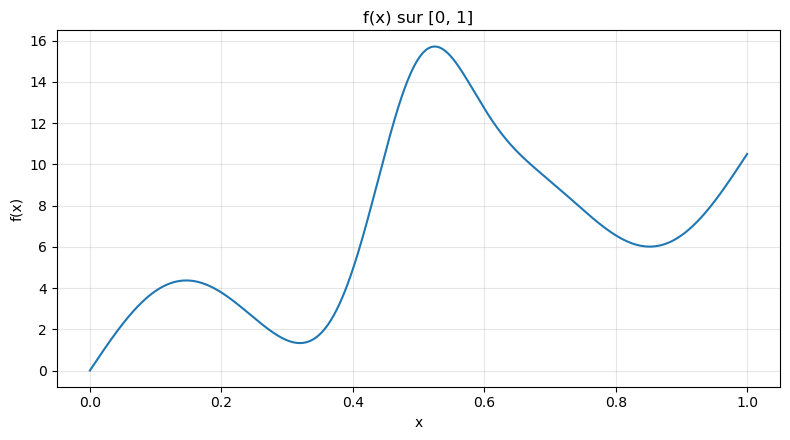

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Paramètres du problème
# =========================
a, b, c = 0.5, 10, 3
Left, Right = 0.0, 1.0
tol = 1e-3  # objectif d'erreur

def f(x):
    """Fonction à intégrer."""
    return a*x**2 + b*x + c*np.sin(4*np.pi*x) + 10*np.exp(-100*(x-0.5)**2)

# =========================
# 1) Intégrale de Riemann
# =========================
def riemann_integral(N):
    """
    Règle du milieu: on évalue f aux milieux des intervalles uniformes.
    """
    dx = (Right - Left) / N
    # points milieux
    x = np.linspace(Left, Right, N, endpoint=False) + dx/2
    return np.sum(f(x)) * dx

def refine_riemann(tol=1e-3, N0=128, max_iters=30, verbose=True):
    N = N0
    I_prev = riemann_integral(N)
    log = [(N, I_prev, np.nan)]
    if verbose:
        print(f"--- Raffinement Riemann (milieu) — tol={tol} ---")
        print(f"  N={N:<8d} I≈ {I_prev:.8f}")
    for _ in range(max_iters):
        N *= 2
        I_new = riemann_integral(N)
        err = abs(I_new - I_prev)
        log.append((N, I_new, err))
        if verbose:
            print(f"  N={N:<8d} I≈ {I_new:.8f}  |Δ|={err:.6e}")
        if err < tol:
            break
        I_prev = I_new
    if verbose:
        print(f"=> Riemann (milieu): I≈ {I_new:.8f} avec N={N} (|Δ|≈ {err:.3e})\n")
    return N, I_new, err, log

# =========================
# 2) Intégrale "Lebesgue" (approx niveaux)
# =========================
def lebesgue_integral(N, M):
    """
    Approxime ∫ f(x) dx par une somme sur les niveaux y:
    ∫_f = ∫_y mes{ x | f(x) ≥ y } dy
    Ici, on estime la mesure par échantillonnage uniforme en x.
    """
    # échantillons en x (milieux)
    dx = (Right - Left) / N
    x = np.linspace(Left, Right, N, endpoint=False) + dx/2
    fx = f(x)

    fmin, fmax = fx.min(), fx.max()
    # M intervalles de niveaux => M milieux
    edges = np.linspace(fmin, fmax, M+1)
    mids  = 0.5 * (edges[:-1] + edges[1:])
    dy    = edges[1] - edges[0]

    # Tri pour compter efficacement combien de fx >= y
    fx_sorted = np.sort(fx)
    # Pour chaque niveau y, position du premier fx >= y
    idxs = np.searchsorted(fx_sorted, mids, side="left")
    counts = (N - idxs)                 # nb de points >= y
    measure = counts * dx               # mesure ≈ nb_points * dx
    return np.sum(measure * dy)

def refine_lebesgue(tol=1e-3, N0=2048, M0=64, growth=2, max_iters=30, verbose=True):
    N, M = N0, M0
    I_prev = lebesgue_integral(N, M)
    log = [(N, M, I_prev, np.nan)]
    if verbose:
        print(f"--- Raffinement Lebesgue (niveaux) — tol={tol} ---")
        print(f"  N={N:<8d} M={M:<6d} I≈ {I_prev:.8f}")
    for _ in range(max_iters):
        N = int(N * growth)
        M = int(M * growth)
        I_new = lebesgue_integral(N, M)
        err = abs(I_new - I_prev)
        log.append((N, M, I_new, err))
        if verbose:
            print(f"  N={N:<8d} M={M:<6d} I≈ {I_new:.8f}  |Δ|={err:.6e}")
        if err < tol:
            break
        I_prev = I_new
    if verbose:
        print(f"=> Lebesgue (approx.): I≈ {I_new:.8f} avec N={N}, M={M} (|Δ|≈ {err:.3e})\n")
    return N, M, I_new, err, log

# =========================
# Lancer les deux raffinements
# =========================
if __name__ == "__main__":
    # Raffinement Riemann
    N_r, I_r, err_r, log_r = refine_riemann(tol=tol, N0=128)

    # Raffinement Lebesgue
    N_l, M_l, I_l, err_l, log_l = refine_lebesgue(tol=tol, N0=2048, M0=64, growth=2)

    # Tracé de f(x)
    xs = np.linspace(Left, Right, 2000)
    plt.figure(figsize=(8,4.5))
    plt.plot(xs, f(xs))
    plt.title("f(x) sur [0, 1]")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Référence très précise (Simpson adaptatif): I_ref ≈ 6.939120517569
Riemann N=16    I≈ 6.9389577571  err=1.628e-04
Riemann N=32    I≈ 6.9390798275  err=4.069e-05
Riemann N=64    I≈ 6.9391103450  err=1.017e-05
Riemann N=128   I≈ 6.9391179744  err=2.543e-06
Riemann N=256   I≈ 6.9391198818  err=6.358e-07
Riemann N=512   I≈ 6.9391203586  err=1.589e-07
Riemann N=1024  I≈ 6.9391204778  err=3.974e-08
Riemann N=2048  I≈ 6.9391205076  err=9.934e-09
Riemann N=4096  I≈ 6.9391205151  err=2.484e-09
Riemann N=8192  I≈ 6.9391205169  err=6.209e-10
Lebesgue N=256    M=64    I≈ 6.8422520755  err=9.687e-02
Lebesgue N=512    M=90    I≈ 6.8934503694  err=4.567e-02
Lebesgue N=1024   M=128   I≈ 6.9158909040  err=2.323e-02
Lebesgue N=2048   M=181   I≈ 6.9266218641  err=1.250e-02
Lebesgue N=4096   M=256   I≈ 6.9335829886  err=5.538e-03
Lebesgue N=8192   M=362   I≈ 6.9362637448  err=2.857e-03
Lebesgue N=16384  M=512   I≈ 6.9376486351  err=1.472e-03
Lebesgue N=32768  M=724   I≈ 6.9383473259  err=7.732e-04

Ordre 

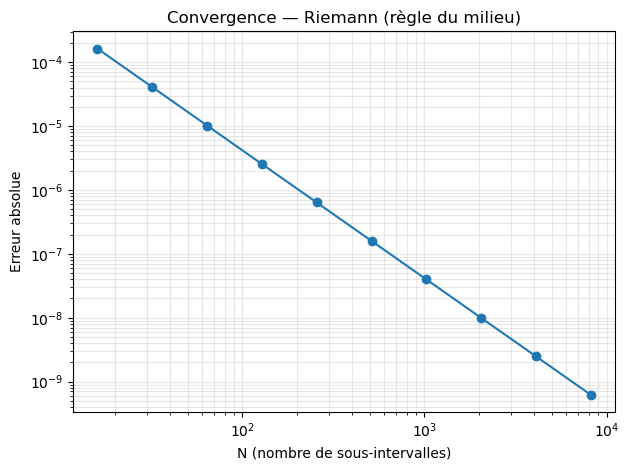

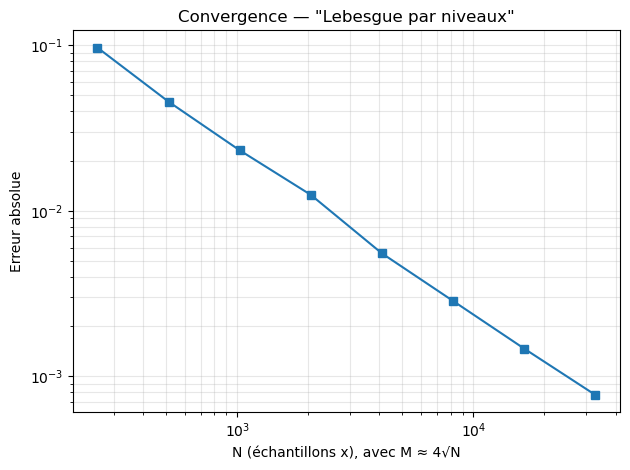

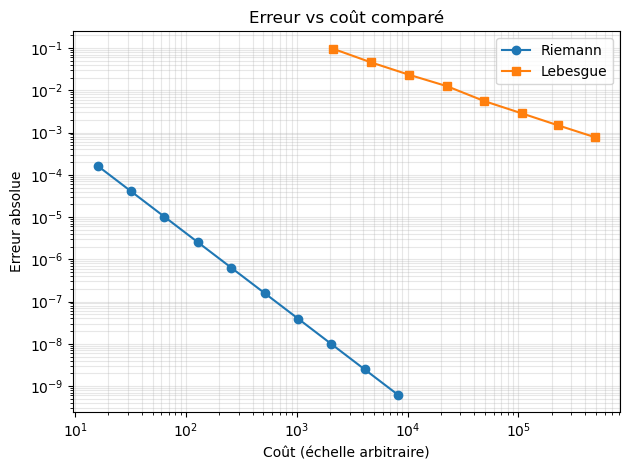

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from math import isfinite

# =========================
# Problème
# =========================
a, b, c = 0.5, 10, 3
Left, Right = 0.0, 1.0

def f(x):
    return a*x**2 + b*x + c*np.sin(4*np.pi*x) + 10*np.exp(-100*(x-0.5)**2)

# =========================
# Référence: Simpson adaptatif
# =========================
def simpson(f, a, b):
    c = (a+b)/2
    h = b-a
    return (h/6)*(f(a) + 4*f(c) + f(b))

def adaptive_simpson(f, a, b, eps=1e-12, maxdepth=30):
    """ Simpson adaptatif récursif (Robustifié). """
    def recurse(f, a, b, eps, S, fa, fb, fc, depth):
        c = (a+b)/2
        h = b-a
        d = (a+c)/2
        e = (c+b)/2
        fd, fe = f(d), f(e)
        Sleft  = (h/12)*(fa + 4*fd + fc)
        Sright = (h/12)*(fc + 4*fe + fb)
        S2 = Sleft + Sright
        if depth <= 0 or not (isfinite(S2) and isfinite(S)):
            return S2
        if abs(S2 - S) <= 15*eps:
            return S2 + (S2 - S)/15
        return (recurse(f, a, c, eps/2, Sleft,  fa, fc, fd, depth-1) +
                recurse(f, c, b, eps/2, Sright, fc, fb, fe, depth-1))
    fa, fb, fc = f(a), f(b), f((a+b)/2)
    S = simpson(f, a, b)
    return recurse(f, a, b, eps, S, fa, fb, fc, maxdepth)

I_ref = adaptive_simpson(f, Left, Right, eps=1e-13, maxdepth=40)
print(f"Référence très précise (Simpson adaptatif): I_ref ≈ {I_ref:.12f}")

# =========================
# Méthodes étudiées
# =========================
def riemann_midpoint(N):
    """Somme de Riemann - règle du milieu."""
    dx = (Right - Left)/N
    x = np.linspace(Left, Right, N, endpoint=False) + dx/2
    return np.sum(f(x))*dx

def lebesgue_levels(N, M):
    """
    Approx. "Lebesgue par niveaux":
      ∫ f = ∫_y mes{ x | f(x) ≥ y } dy,
    mesure estimée par échantillonnage uniforme en x.
    """
    dx = (Right - Left)/N
    x = np.linspace(Left, Right, N, endpoint=False) + dx/2
    fx = f(x)
    fmin, fmax = fx.min(), fx.max()
    edges = np.linspace(fmin, fmax, M+1)
    mids  = 0.5*(edges[:-1] + edges[1:])
    dy    = edges[1] - edges[0]
    fx_sorted = np.sort(fx)
    idxs = np.searchsorted(fx_sorted, mids, side="left")
    counts = (N - idxs)           # nb de points fx >= y
    measure = counts * dx         # mesure ≈ nb_points*dx
    return np.sum(measure * dy)

# =========================
# Balayage de convergence
# =========================
# Riemann: N = 2^k
Ns_riem = [2**k for k in range(4, 14)]  # 16 -> 8192
riem_I = []
riem_err = []
for N in Ns_riem:
    I = riemann_midpoint(N)
    riem_I.append(I)
    riem_err.append(abs(I - I_ref))
    print(f"Riemann N={N:<5d} I≈ {I:.10f}  err={abs(I-I_ref):.3e}")

# Lebesgue: lier M à N pour convergence conjointe (ex: M ≈ 4√N)
Ns_leb = [2**k for k in range(8, 16)]   # 256 -> 65536
leb_I = []
leb_err = []
Ms_leb = []
for N in Ns_leb:
    M = max(8, int(4*np.sqrt(N)))
    Ms_leb.append(M)
    I = lebesgue_levels(N, M)
    leb_I.append(I)
    leb_err.append(abs(I - I_ref))
    print(f"Lebesgue N={N:<6d} M={M:<5d} I≈ {I:.10f}  err={abs(I-I_ref):.3e}")

# =========================
# Estimation d'ordre (pente log-log)
# =========================
def estimate_order(Ns, errs):
    Ns = np.array(Ns, dtype=float)
    errs = np.array(errs, dtype=float)
    mask = errs > 0
    Ns, errs = Ns[mask], errs[mask]
    # régression linéaire sur les derniers points (régime asymptotique)
    k = max(3, len(Ns)//2)
    X = np.log(Ns[-k:])
    Y = np.log(errs[-k:])
    A = np.vstack([X, np.ones_like(X)]).T
    slope, intercept = np.linalg.lstsq(A, Y, rcond=None)[0]
    return slope  # pour err ~ N^slope

slope_riem = estimate_order(Ns_riem, riem_err)   # attendu ~ -2
slope_leb  = estimate_order(Ns_leb,  leb_err)    # empirique ~ -1 ici

print(f"\nOrdre empirique (pente log-log) — Riemann (milieu) : {slope_riem:.2f}")
print(f"Ordre empirique (pente log-log) — Lebesgue (M ≈ 4√N) : {slope_leb:.2f}")

# =========================
# Graphiques
# =========================
# Erreur vs N (Riemann)
plt.figure()
plt.loglog(Ns_riem, riem_err, marker='o')
plt.xlabel("N (nombre de sous-intervalles)")
plt.ylabel("Erreur absolue")
plt.title("Convergence — Riemann (règle du milieu)")
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

# Erreur vs N (Lebesgue)
plt.figure()
plt.loglog(Ns_leb, leb_err, marker='s')
plt.xlabel("N (échantillons x), avec M ≈ 4√N")
plt.ylabel("Erreur absolue")
plt.title('Convergence — "Lebesgue par niveaux"')
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

# Bonus : Erreur vs "coût" approx.
def cost_riem(N): return N
def cost_leb(N, M): return N*np.log2(N+1) + M  # coût tri + niveaux (échelle arbitraire)

plt.figure()
plt.loglog([cost_riem(N) for N in Ns_riem], riem_err, marker='o', label="Riemann")
plt.loglog([cost_leb(N, M) for N, M in zip(Ns_leb, Ms_leb)], leb_err, marker='s', label="Lebesgue")
plt.xlabel("Coût (échelle arbitraire)")
plt.ylabel("Erreur absolue")
plt.title("Erreur vs coût comparé")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import math

# -----------------------------------
# Problème
# -----------------------------------
a, b, c = 0.5, 10, 3
Left, Right = 0.0, 1.0

def f(x):
    return a*x**2 + b*x + c*np.sin(4*np.pi*x) + 10*np.exp(-100*(x-0.5)**2)

# -----------------------------------
# Intégrateurs de base
# -----------------------------------
def riemann_midpoint(N):
    """Somme de Riemann (règle du milieu) sur N sous-intervalles uniformes."""
    dx = (Right - Left)/N
    x = np.linspace(Left, Right, N, endpoint=False) + dx/2
    return np.sum(f(x))*dx

def lebesgue_levels(N, M):
    """
    Approximation "Lebesgue par niveaux":
      ∫ f = ∫_y mes{ x | f(x) ≥ y } dy,
    mesure estimée par échantillonnage uniforme en x.
    """
    dx = (Right - Left)/N
    x = np.linspace(Left, Right, N, endpoint=False) + dx/2
    fx = f(x)
    fmin, fmax = fx.min(), fx.max()
    edges = np.linspace(fmin, fmax, M+1)
    mids  = 0.5*(edges[:-1] + edges[1:])
    dy    = edges[1] - edges[0]
    fx_sorted = np.sort(fx)
    idxs = np.searchsorted(fx_sorted, mids, side="left")
    counts = (N - idxs)
    measure = counts * dx
    return np.sum(measure * dy)

# -----------------------------------
# Critère de Cauchy (|I_{k+1} - I_k| < tol)
# -----------------------------------
def refine_riemann_cauchy(tol=1e-3, N0=64, growth=2, max_iters=30, min_iters=1, verbose=True):
    """
    Raffine N -> growth*N tant que |I_{k+1}-I_k| >= tol.
    Renvoie (N_final, I_final, err_est, historique)
    """
    N = int(N0)
    I_prev = riemann_midpoint(N)
    hist = [(N, I_prev, math.nan)]
    if verbose:
        print(f"--- Cauchy: Riemann (milieu), tol={tol} ---")
        print(f"  N={N:<8d} I≈ {I_prev:.8f}")

    for it in range(max_iters):
        N = int(max(2, growth*N))
        I_new = riemann_midpoint(N)
        err = abs(I_new - I_prev)
        hist.append((N, I_new, err))
        if verbose:
            print(f"  N={N:<8d} I≈ {I_new:.8f}  |Δ|={err:.6e}")
        if it+1 >= min_iters and err < tol:
            if verbose:
                print(f"=> STOP: |Δ|<{tol}  → I≈ {I_new:.8f} avec N={N} (|Δ|≈ {err:.3e})\n")
            return N, I_new, err, hist
        I_prev = I_new

    if verbose:
        print("Attention: max_iters atteint sans satisfaire le critère de Cauchy.\n")
    return N, I_prev, err, hist

def refine_lebesgue_cauchy(tol=1e-3, N0=1024, M0=64, growthN=2, growthM=2,
                           max_iters=30, min_iters=1, verbose=True):
    """
    Raffine (N, M) -> (growthN*N, growthM*M) tant que |I_{k+1}-I_k| >= tol.
    Renvoie (N_final, M_final, I_final, err_est, historique)
    """
    N, M = int(N0), int(M0)
    I_prev = lebesgue_levels(N, M)
    hist = [(N, M, I_prev, math.nan)]
    if verbose:
        print(f"--- Cauchy: Lebesgue (niveaux), tol={tol} ---")
        print(f"  N={N:<8d} M={M:<6d} I≈ {I_prev:.8f}")

    for it in range(max_iters):
        N = int(max(2, growthN*N))
        M = int(max(8, growthM*M))
        I_new = lebesgue_levels(N, M)
        err = abs(I_new - I_prev)
        hist.append((N, M, I_new, err))
        if verbose:
            print(f"  N={N:<8d} M={M:<6d} I≈ {I_new:.8f}  |Δ|={err:.6e}")
        if it+1 >= min_iters and err < tol:
            if verbose:
                print(f"=> STOP: |Δ|<{tol}  → I≈ {I_new:.8f} avec N={N}, M={M} (|Δ|≈ {err:.3e})\n")
            return N, M, I_new, err, hist
        I_prev = I_new

    if verbose:
        print("Attention: max_iters atteint sans satisfaire le critère de Cauchy.\n")
    return N, M, I_prev, err, hist

# -----------------------------------
# Exemple d’utilisation
# -----------------------------------
if __name__ == "__main__":
    tol = 1e-3

    # Riemann (milieu) — raffinement par Cauchy
    N_r, I_r, err_r, hist_r = refine_riemann_cauchy(tol=tol, N0=128, growth=2)

    # Lebesgue (niveaux) — raffinement par Cauchy
    N_l, M_l, I_l, err_l, hist_l = refine_lebesgue_cauchy(
        tol=tol, N0=2048, M0=64, growthN=2, growthM=2
    )

    # Valeurs finales
    print(f"Résultat Riemann : I ≈ {I_r:.8f} (N={N_r}, |Δ|≈{err_r:.2e})")
    print(f"Résultat Lebesgue : I ≈ {I_l:.8f} (N={N_l}, M={M_l}, |Δ|≈{err_l:.2e})")


--- Cauchy: Riemann (milieu), tol=0.001 ---
  N=128      I≈ 6.93911797
  N=256      I≈ 6.93911988  |Δ|=1.907349e-06
=> STOP: |Δ|<0.001  → I≈ 6.93911988 avec N=256 (|Δ|≈ 1.907e-06)

--- Cauchy: Lebesgue (niveaux), tol=0.001 ---
  N=2048     M=64     I≈ 6.92954975
  N=4096     M=128    I≈ 6.93322357  |Δ|=3.673822e-03
  N=8192     M=256    I≈ 6.93646004  |Δ|=3.236469e-03
  N=16384    M=512    I≈ 6.93764864  |Δ|=1.188596e-03
  N=32768    M=1024   I≈ 6.93847115  |Δ|=8.225141e-04
=> STOP: |Δ|<0.001  → I≈ 6.93847115 avec N=32768, M=1024 (|Δ|≈ 8.225e-04)

Résultat Riemann : I ≈ 6.93911988 (N=256, |Δ|≈1.91e-06)
Résultat Lebesgue : I ≈ 6.93847115 (N=32768, M=1024, |Δ|≈8.23e-04)


NX= 8 Dt= 0.05172084342023556
iter= 33 residual= 0.0006021986455240495
iter= 33 time= 1.7067878328677741 residual= 0.0006021986455240495
norm error L2, H1= 0.15967409082372994 2.1050625367114155
----------------------------------
NX= 25 Dt= 0.01180541602068137
iter= 112 residual= 0.0016841739743769213
iter= 112 time= 1.322206594316313 residual= 0.0016841739743769213
norm error L2, H1= 0.019131897048811082 4.588746719770155
----------------------------------
NX= 54 Dt= 0.003225367377382263
iter= 373 residual= 0.0011938429525965532
cauchy= 13.904046260581637
iter= 373 time= 1.2030620317635816 residual= 0.0011938429525965532
norm error L2, H1= 0.004094511815004979 1.3900436326865178
----------------------------------
NX= 60 Dt= 0.0031197821759974113
iter= 395 residual= 0.001242555251388178
cauchy= 11.261588915642264
iter= 395 time= 1.2323139595189732 residual= 0.001242555251388178
norm error L2, H1= 0.0060823662229418304 1.0592174631138103
----------------------------------
NX= 60 Dt= 0.0

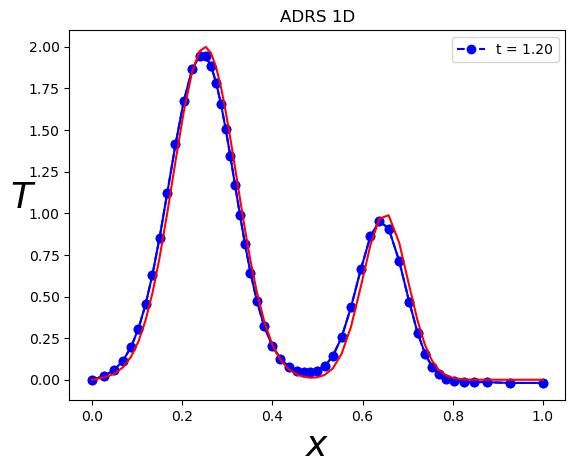

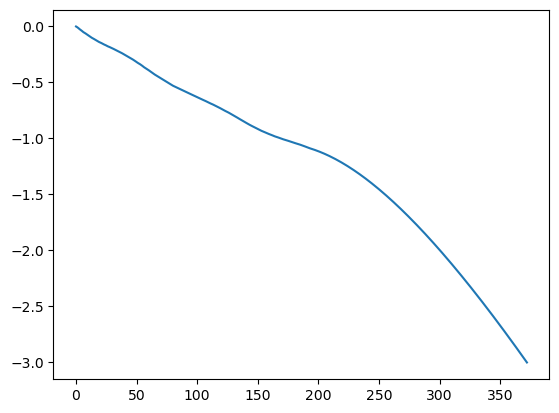

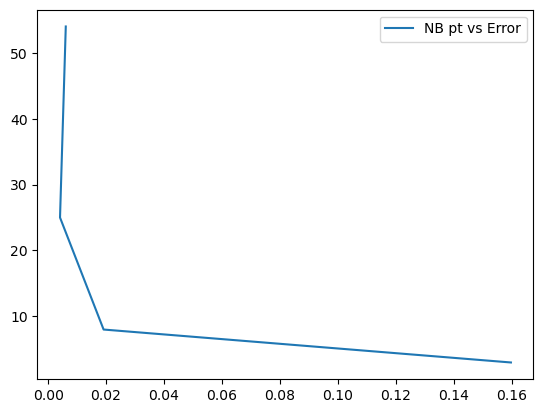

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
import sys

def adrs_fct(n, x):
#u,t = -V u,x + k u,xx  -lamda u + f
    u=np.ones(n)
    return u

def metric_fct(n, u):
#calcul metric hloc
    hloc=np.ones(n)
    return hloc

def mesh_fct(n, hloc):
#calcul metric hloc
    x=np.ones(n)
    return x

iplot=0

# PHYSICAL PARAMETERS
K = 0.01     #Diffusion coefficient
xmin = 0.0
xmax = 1.0    
Time = 10.  #Integration time

V=1.
lamda=1

#mesh adaptation param

niter_refinement=30      #niter different calculations
hmin=0.01
hmax=0.15
err=0.03

# NUMERICAL PARAMETERS
NX = 3    #Number of grid points : initialization
NT = 10000   #Number of time steps max
ifre=1000000  #plot every ifre time iterations
eps=0.001     #relative convergence ratio

errorL2=np.zeros((niter_refinement))
errorH1=np.zeros((niter_refinement))
itertab=np.zeros((niter_refinement))
hloc = np.ones((NX))*hmax

NX_background=200
background_mesh=np.arange(NX_background)*(xmax-xmin)*0.005
Tbacknew=[]        

itera=0
NX0=0
while( np.abs(NX0-NX) > 2 and itera<niter_refinement-1):

    itera+=1
    itertab[itera]=1./NX

    iplot=itera-2
    
    x = np.linspace(xmin,xmax,NX)
    T = np.zeros((NX))

#mesh adaptation using local metric
    if(itera>0):
        xnew=[]
        Tnew=[]
        nnew=1
        xnew.append(xmin)
        Tnew.append(T[0])
        while(xnew[nnew-1] < xmax-hmin):
            for i in range(0,NX-1):
                if(xnew[nnew-1] >= x[i] and xnew[nnew-1] <= x[i+1] and xnew[nnew-1]<xmax-hmin):
                    hll=(hloc[i]*(x[i+1]-xnew[nnew-1])+hloc[i+1]*(xnew[nnew-1]-x[i]))/(x[i+1]-x[i])
                    hll=min(max(hmin,hll),hmax)
                    nnew+=1
#                    print(nnew,hll,min(xmax,xnew[nnew-2]+hll))
                    xnew.append(min(xmax,xnew[nnew-2]+hll))                
#solution interpolation for initialization (attention initial solution on first mesh in the row)
                    un=(T[i]*(x[i+1]-xnew[nnew-1])+T[i+1]*(xnew[nnew-1]-x[i]))/(x[i+1]-x[i])
                    Tnew.append(un)
                    
        NX0=NX
        NX=nnew
        x = np.zeros((NX))
        x[0:NX]=xnew[0:NX]
        T = np.zeros((NX))
        T[0:NX]=Tnew[0:NX]
#        T[NX-1]=0
    
    rest = []
    F = np.zeros((NX))
    RHS = np.zeros((NX))
    hloc = np.ones((NX))*hmax*0.5
    metric = np.ones((NX))

    Tex = np.zeros((NX))
    for j in range (1,NX-1):
        Tex[j] = 2*np.exp(-100*(x[j]-(xmax+xmin)*0.25)**2)+np.exp(-200*(x[j]-(xmax+xmin)*0.65)**2)
        
    dt=1.e30
    for j in range (1,NX-1):
        Tx=(Tex[j+1]-Tex[j-1])/(x[j+1]-x[j-1])
        Txip1=(Tex[j+1]-Tex[j])/(x[j+1]-x[j])
        Txim1=(Tex[j]-Tex[j-1])/(x[j]-x[j-1])
        Txx=(Txip1-Txim1)/(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))
        F[j]=V*Tx-K*Txx+lamda*Tex[j]
        dt=min(dt,0.5*(x[j+1]-x[j-1])**2/(V*np.abs(x[j+1]-x[j-1])+4*K+np.abs(F[j])*(x[j+1]-x[j-1])**2))

    print('NX=',NX,'Dt=',dt)        


    if(iplot==1):
        plt.figure(1)

    #time step loop
    n=0
    res=1
    res0=1
    t=0
    while(n<NT and res/res0>eps and t<Time):
        n+=1
        t+=dt
    #discretization of the advection/diffusion/reaction/source equation
        res=0
        for j in range (1, NX-1):
            visnum=0.5*(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))*np.abs(V)
            xnu=K+visnum            
            Tx=(T[j+1]-T[j-1])/(x[j+1]-x[j-1])
            Txip1=(T[j+1]-T[j])/(x[j+1]-x[j])
            Txim1=(T[j]-T[j-1])/(x[j]-x[j-1])
            Txx=(Txip1-Txim1)/(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))            
            RHS[j] = dt*(-V*Tx+xnu*Txx-lamda*T[j]+F[j])
            metric[j]=min(1./hmin**2,max(1./hmax**2,abs(Txx)/err))
            res+=abs(RHS[j])

        metric[0]=metric[1]
        
        metric[NX-1]=metric[NX-2]    #ux a droite = 0
        #metric[NX-1]=2*metric[NX-2]-metric[NX-3]   #uxx a droite =0

        for j in range (0, NX-1):
            metric[j]=0.5*(metric[j]+metric[j+1])
        metric[NX-1]=metric[NX-2]
        
        hloc[0:NX]=np.sqrt(1./metric[0:NX])

        for j in range (1, NX-1):
            T[j] += RHS[j]
            RHS[j]=0
        
        T[NX-1]=T[NX-2] #1.2*T[NX-2]-0.2*T[NX-3]

        if (n == 1 ):
            res0=res

        rest.append(res)
    #Plot every ifre time steps
        if (n%ifre == 0 or (res/res0)<eps):
            print('iter=',n,'residual=',res)
            if(iplot==1):
                plotlabel = "t = %1.2f" %(n * dt)
                plt.plot(x[0:NX],T[0:NX], label=plotlabel,linestyle='--', marker='o', color='b')

    
    Tbackold=Tbacknew.copy()

#solution interpolation to background mesh    
    Tbacknew=[]        
    #Tbacknew.append(T[0])        
    for i in range(NX_background):
        for inew in range(nnew-1):
            if(background_mesh[i] >= xnew[inew] and background_mesh[i] <= xnew[inew+1]):
                un=(T[inew+1]*(background_mesh[i]-xnew[inew])+T[inew]*(xnew[inew+1]-background_mesh[i]))/(xnew[inew+1]-xnew[inew])
                Tbacknew.append(un)

    Tbacknew=np.array(Tbacknew)

    if(len(Tbacknew)==len(Tbackold)):
        cauchy=np.sum(np.abs(Tbacknew-Tbackold))
        print("cauchy=",cauchy)    
        # plt.plot(Tbacknew)
        # plt.plot(Tbackold)
        # plt.show()
    

    print('iter=',n,'time=',t,'residual=',res)
    if(iplot==1):
        plt.plot(x[0:NX],T[0:NX],marker='o', color='b')
        plt.plot(x[0:NX],Tex[0:NX],color='r')        
        plt.xlabel(u'$x$', fontsize=26)
        plt.ylabel(u'$T$', fontsize=26, rotation=0)
        plt.title(u'ADRS 1D')
        plt.legend()
        plt.figure(2)
        plt.plot(np.log10(rest/rest[0]))


#    errL2=np.sqrt(np.dot(T-Tex,T-Tex))
    errH1h=0
    errL2h=0
    for j in range (1, NX-1):
        Texx=(Tex[j+1]-Tex[j-1])/(x[j+1]-x[j-1])
        Tx=(T[j+1]-T[j-1])/(x[j+1]-x[j-1])
        errL2h+=(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))*(T[j]-Tex[j])**2
        errH1h+=(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))*(Tx-Texx)**2

    errorL2[itera]=errL2h
    errorH1[itera]=errL2h+errH1h
    
    
    print('norm error L2, H1=',errL2h,errH1h)
    print('----------------------------------')

if(iplot==-1):
    plt.figure(3)
    plt.plot(itertab,np.log10(errorL2))
    plt.plot(itertab,np.log10(errorH1))

plt.show()


plt.plot(errorL2[1:itera],1/itertab[1:itera],label="NB pt vs Error")
plt.legend()
plt.show()

#plt.plot(hloc)

NX= 8 Dt= 0.05172084342023556
iter= 33 residual= 0.0006021986455240495
iter= 33 time= 1.7067878328677741 residual= 0.0006021986455240495
norm error L2, H1= 0.15967409082372994 2.1050625367114155
----------------------------------
NX= 25 Dt= 0.01180541602068137
iter= 112 residual= 0.0016841739743769213
iter= 112 time= 1.322206594316313 residual= 0.0016841739743769213
Cauchy Ik = 4.184e-01
norm error L2, H1= 0.019131897048811082 4.588746719770155
----------------------------------
NX= 43 Dt= 0.007634889695081362
iter= 163 residual= 0.0019908528342445124
iter= 163 time= 1.2444870202982634 residual= 0.0019908528342445124
Cauchy Ik = 7.020e-02
norm error L2, H1= 0.006671865858585013 2.1428120091486074
----------------------------------
NX= 44 Dt= 0.007898086678036072
iter= 158 residual= 0.0021023976231632994
iter= 158 time= 1.2478976951296974 residual= 0.0021023976231632994
Cauchy Ik = 1.289e-02
norm error L2, H1= 0.006170518730098248 2.0272117740400306
----------------------------------


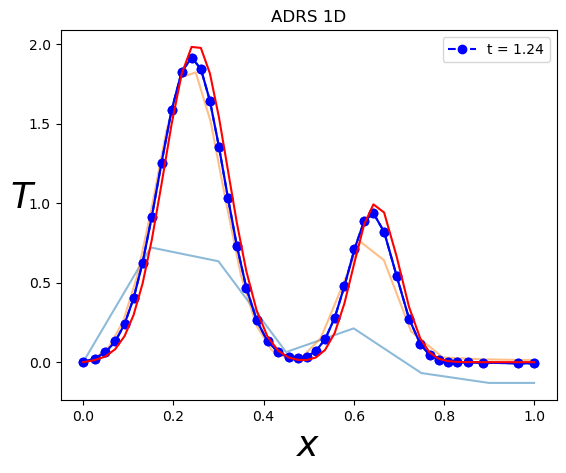

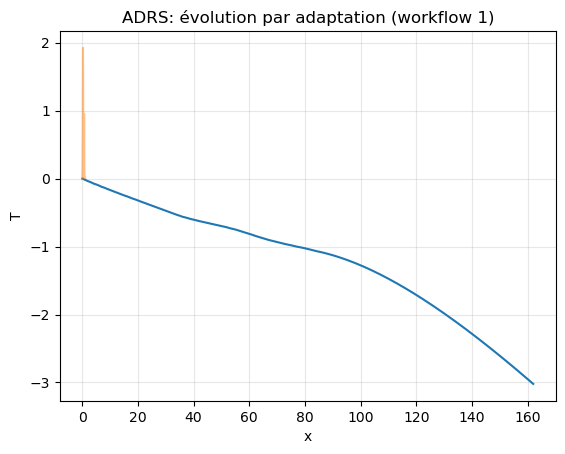

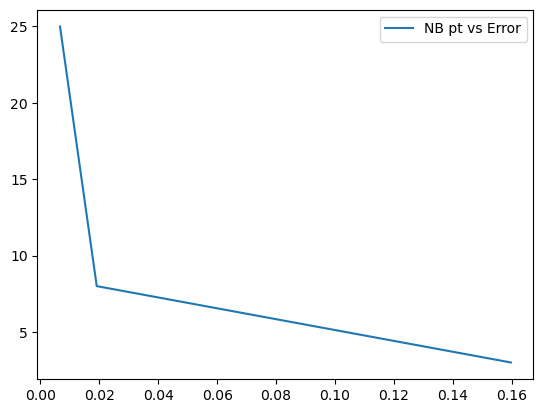

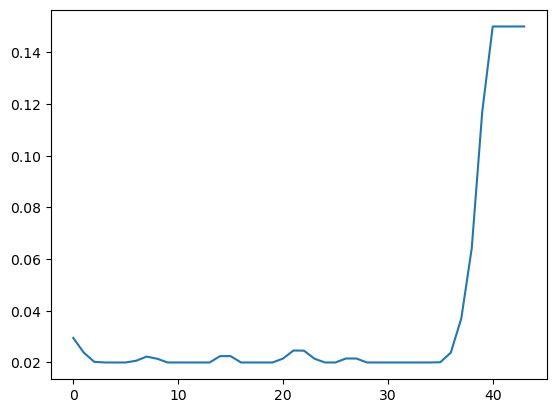

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt

def adrs_fct(n, x):
#u,t = -V u,x + k u,xx  -lamda u + f
    u=np.ones(n)
    return u

def metric_fct(n, u):
#calcul metric hloc
    hloc=np.ones(n)
    return hloc

def mesh_fct(n, hloc):
#calcul metric hloc
    x=np.ones(n)
    return x

iplot=0

# PHYSICAL PARAMETERS
K = 0.01     #Diffusion coefficient
xmin = 0.0
xmax = 1.0    
Time = 10.  #Integration time

V=1.
lamda=1

# ---- (ajout) : background mesh + critère de Cauchy ----
xB = np.linspace(xmin, xmax, 4000)
tol_cauchy = 1e-3
YB_prev = None
# --------------------------------------------------------

# ---- (ajout) : figure pour tracé multi-étapes ----------
show_progress = True
plt.figure("Evolution T(x) par adaptation - WF1")
# --------------------------------------------------------

# mesh adaptation param
niter_refinement=30
hmin=0.02
hmax=0.15
err=0.03

# NUMERICAL PARAMETERS
NX = 3
NT = 10000
ifre=1000000
eps=0.001

errorL2=np.zeros((niter_refinement))
errorH1=np.zeros((niter_refinement))
itertab=np.zeros((niter_refinement))
hloc = np.ones((NX))*hmax

itera=0
NX0=0
while( np.abs(NX0-NX) > 2 and itera<niter_refinement-1):

    itera+=1
    itertab[itera]=1./NX

    iplot=itera-2
    
    x = np.linspace(xmin,xmax,NX)
    T = np.zeros((NX))

    # mesh adaptation using local metric
    if(itera>0):
        xnew=[]
        Tnew=[]        
        nnew=1
        xnew.append(xmin)
        Tnew.append(T[0])        
        while(xnew[nnew-1] < xmax-hmin):
            for i in range(0,NX-1):
                if(xnew[nnew-1] >= x[i] and xnew[nnew-1] <= x[i+1] and xnew[nnew-1]<xmax-hmin):
                    hll=(hloc[i]*(x[i+1]-xnew[nnew-1])+hloc[i+1]*(xnew[nnew-1]-x[i]))/(x[i+1]-x[i])
                    hll=min(max(hmin,hll),hmax)
                    nnew+=1
                    xnew.append(min(xmax,xnew[nnew-2]+hll))
                    # interpolation de T (initialisation)
                    un=(T[i]*(x[i+1]-xnew[nnew-1])+T[i+1]*(xnew[nnew-1]-x[i]))/(x[i+1]-x[i])
                    Tnew.append(un)
                    
        NX0=NX
        NX=nnew
        x = np.zeros((NX))
        x[0:NX]=xnew[0:NX]
        T = np.zeros((NX))
        T[0:NX]=Tnew[0:NX]
    
    rest = []
    F = np.zeros((NX))
    RHS = np.zeros((NX))
    hloc = np.ones((NX))*hmax*0.5
    metric = np.ones((NX))

    Tex = np.zeros((NX))
    for j in range (1,NX-1):
        Tex[j] = 2*np.exp(-100*(x[j]-(xmax+xmin)*0.25)**2)+np.exp(-200*(x[j]-(xmax+xmin)*0.65)**2)
        
    dt=1.e30
    for j in range (1,NX-1):
        Tx=(Tex[j+1]-Tex[j-1])/(x[j+1]-x[j-1])
        Txip1=(Tex[j+1]-Tex[j])/(x[j+1]-x[j])
        Txim1=(Tex[j]-Tex[j-1])/(x[j]-x[j-1])
        Txx=(Txip1-Txim1)/(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))
        F[j]=V*Tx-K*Txx+lamda*Tex[j]
        dt=min(dt,0.5*(x[j+1]-x[j-1])**2/(V*np.abs(x[j+1]-x[j-1])+4*K+np.abs(F[j])*(x[j+1]-x[j-1])**2))

    print('NX=',NX,'Dt=',dt)        

    if(iplot==1):
        plt.figure(1)

    # time step loop
    n=0
    res=1
    res0=1
    t=0
    while(n<NT and res/res0>eps and t<Time):
        n+=1
        t+=dt
        res=0
        for j in range (1, NX-1):
            visnum=0.5*(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))*np.abs(V)
            xnu=K+visnum            
            Tx=(T[j+1]-T[j-1])/(x[j+1]-x[j-1])
            Txip1=(T[j+1]-T[j])/(x[j+1]-x[j])
            Txim1=(T[j]-T[j-1])/(x[j]-x[j-1])
            Txx=(Txip1-Txim1)/(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))            
            RHS[j] = dt*(-V*Tx+xnu*Txx-lamda*T[j]+F[j])
            metric[j]=min(1./hmin**2,max(1./hmax**2,abs(Txx)/err))
            res+=abs(RHS[j])

        metric[0]=metric[1]
        metric[NX-1]=metric[NX-2]

        for j in range (0, NX-1):
            metric[j]=0.5*(metric[j]+metric[j+1])
        metric[NX-1]=metric[NX-2]
        
        hloc[0:NX]=np.sqrt(1./metric[0:NX])

        for j in range (1, NX-1):
            T[j] += RHS[j]
            RHS[j]=0
        
        T[NX-1]=T[NX-2]

        if (n == 1 ):
            res0=res

        rest.append(res)

        if (n%ifre == 0 or (res/res0)<eps):
            print('iter=',n,'residual=',res)
            if(iplot==1):
                plotlabel = "t = %1.2f" %(n * dt)
                plt.plot(x[0:NX],T[0:NX], label=plotlabel,linestyle='--', marker='o', color='b')
          
    print('iter=',n,'time=',t,'residual=',res)

    # ---- (ajout) : tracer la solution à chaque adaptation ----
    if show_progress:
        plt.plot(x, T, '-', alpha=0.5)
    # ----------------------------------------------------------

    # ---- projection background + Cauchy (WF1) ----
    YB = np.interp(xB, x, T)
    if YB_prev is not None:
        Ik = np.sqrt(np.trapz((YB - YB_prev)**2, xB))
        print(f'Cauchy Ik = {Ik:.3e}')
        if Ik < tol_cauchy:
            print('✅ Critère de Cauchy atteint : arrêt de l’adaptation.')
            break
    YB_prev = YB.copy()
    # ----------------------------------------------

    if(iplot==1):
        plt.plot(x[0:NX],T[0:NX],marker='o', color='b')
        plt.plot(x[0:NX],Tex[0:NX],color='r')        
        plt.xlabel(u'$x$', fontsize=26)
        plt.ylabel(u'$T$', fontsize=26, rotation=0)
        plt.title(u'ADRS 1D')
        plt.legend()
        plt.figure(2)
        plt.plot(np.log10(rest/rest[0]))

    errH1h=0
    errL2h=0
    for j in range (1, NX-1):
        Texx=(Tex[j+1]-Tex[j-1])/(x[j+1]-x[j-1])
        Tx=(T[j+1]-T[j-1])/(x[j+1]-x[j-1])
        errL2h+=(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))*(T[j]-Tex[j])**2
        errH1h+=(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))*(Tx-Texx)**2

    errorL2[itera]=errL2h
    errorH1[itera]=errL2h+errH1h
    print('norm error L2, H1=',errL2h,errH1h)
    print('----------------------------------')

# ---- (ajout) : finaliser la figure d’évolution ----
if show_progress:
    plt.xlabel("x"); plt.ylabel("T")
    plt.title("ADRS: évolution par adaptation (workflow 1)")
    plt.grid(True, alpha=0.3)
# --------------------------------------------------

if(iplot==-1):
    plt.figure(3)
    plt.plot(itertab,np.log10(errorL2))
    plt.plot(itertab,np.log10(errorH1))

plt.show()

plt.plot(errorL2[1:itera],1/itertab[1:itera],label="NB pt vs Error")
plt.legend()
plt.show()

plt.plot(hloc)

NX= 8 Dt= 0.05172084342023556
iter= 33 residual= 0.0006021986455240495
iter= 33 time= 1.7067878328677741 residual= 0.0006021986455240495
norm error L2, H1= 0.15967409082372994 2.1050625367114155
----------------------------------
NX= 25 Dt= 0.01178864148943053
iter= 97 residual= 0.0014715386835857688
iter= 97 time= 1.1434982244747607 residual= 0.0014715386835857688
Cauchy Ik = 4.211e-01
norm error L2, H1= 0.018085733097822607 4.522077151124964
----------------------------------
NX= 40 Dt= 0.007430241465423633
iter= 108 residual= 0.0010563628614907168
iter= 108 time= 0.802466078265751 residual= 0.0010563628614907168
Cauchy Ik = 6.932e-02
norm error L2, H1= 0.006385254501066739 2.084604123692186
----------------------------------
NX= 40 Dt= 0.0077083056771561605
iter= 102 residual= 0.0002725602090546944
iter= 102 time= 0.7862471790699288 residual= 0.0002725602090546944
Cauchy Ik = 9.164e-03
norm error L2, H1= 0.006073746151591898 1.9589484836332234
----------------------------------


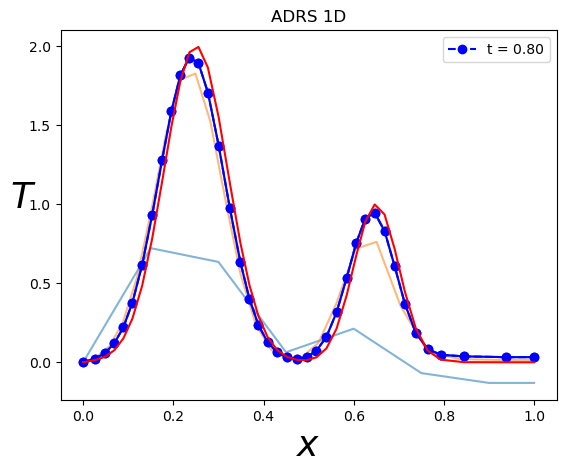

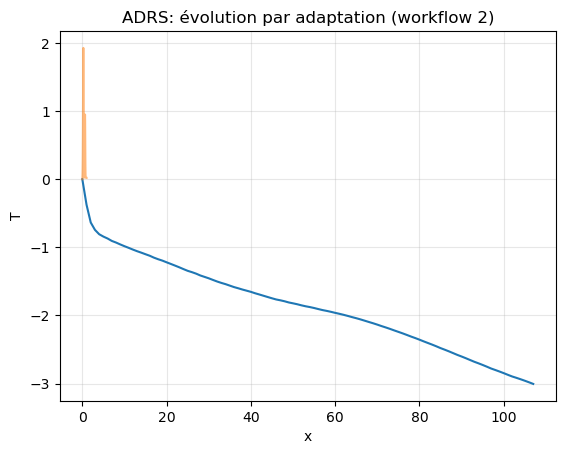

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt

def adrs_fct(n, x):
#u,t = -V u,x + k u,xx  -lamda u + f
    u=np.ones(n)
    return u

def metric_fct(n, u):
#calcul metric hloc
    hloc=np.ones(n)
    return hloc

def mesh_fct(n, hloc):
#calcul metric hloc
    x=np.ones(n)
    return x

iplot=0

# PHYSICAL PARAMETERS
K = 0.01     #Diffusion coefficient
xmin = 0.0
xmax = 1.0    
Time = 10.  #Integration time

V=1.
lamda=1

# >>> MODIF (workflow 2): background mesh + tolérance Cauchy
xB = np.linspace(xmin, xmax, 4000)
tol_cauchy = 1e-3
YB_prev = None
# ----------------------------------------------------------

# >>> MODIF (tracé multi-étapes, minimal)
show_progress = True
plt.figure("Evolution T(x) par adaptation - WF2")
# ----------------------------------------------------------

#mesh adaptation param
niter_refinement=30      #niter different calculations
hmin=0.02
hmax=0.15
err=0.03

# NUMERICAL PARAMETERS
NX = 3    #Number of grid points : initialization
NT = 10000   #Number of time steps max
ifre=1000000  #plot every ifre time iterations
eps=0.001     #relative convergence ratio

errorL2=np.zeros((niter_refinement))
errorH1=np.zeros((niter_refinement))
itertab=np.zeros((niter_refinement))

# >>> MODIF: initialisation unique (x,T) AVANT la boucle
x = np.linspace(xmin, xmax, NX)
T = np.zeros((NX))
# -------------------------------------------------------

hloc = np.ones((NX))*hmax

itera=0
NX0=0
while( np.abs(NX0-NX) > 2 and itera<niter_refinement-1):

    itera+=1
    itertab[itera]=1./NX
    iplot=itera-2

    # >>> MODIF: NE PAS re-créer x,T ici (on garde ceux de l’itération précédente)
    # x = np.linspace(xmin,xmax,NX)
    # T = np.zeros((NX))
    # -------------------------------------------------------------------------

    # >>> MODIF: conserver l’état avant remeshing pour interpolation Y_{k-1}->Mesh_{k}
    x_old = x.copy()
    T_old = T.copy()
    # -------------------------------------------------------------------------

    #mesh adaptation using local metric
    if(itera>0):
        xnew=[]
        Tnew=[]        
        nnew=1
        xnew.append(xmin)
        # >>> MODIF: partir de la vraie solution précédente
        Tnew.append(T_old[0])
        # -----------------------------------------------
        while(xnew[nnew-1] < xmax-hmin):
            for i in range(0,NX-1):
                if(xnew[nnew-1] >= x[i] and xnew[nnew-1] <= x[i+1] and xnew[nnew-1]<xmax-hmin):
                    hll=(hloc[i]*(x[i+1]-xnew[nnew-1])+hloc[i+1]*(xnew[nnew-1]-x[i]))/(x[i+1]-x[i])
                    hll=min(max(hmin,hll),hmax)
                    nnew+=1
                    xnew.append(min(xmax,xnew[nnew-2]+hll))
                    # >>> MODIF: interpolation de Y_{k-1} (T_old) sur le nouveau noeud
                    un=(T_old[i]*(x[i+1]-xnew[nnew-1]) + T_old[i+1]*(xnew[nnew-1]-x[i]))/(x[i+1]-x[i])
                    Tnew.append(un)
                    # ----------------------------------------------------------------

        NX0=NX
        NX=nnew
        # >>> MODIF: ne PAS réinitialiser T à zéro; on prend l’interpolation
        x = np.array(xnew[:NX])
        T = np.array(Tnew[:NX])
        # -------------------------------------------------------------------
        # T[NX-1]=0   # (laisse commenté)

    rest = []
    F = np.zeros((NX))
    RHS = np.zeros((NX))
    hloc = np.ones((NX))*hmax*0.5
    metric = np.ones((NX))

    Tex = np.zeros((NX))
    for j in range (1,NX-1):
        Tex[j] = 2*np.exp(-100*(x[j]-(xmax+xmin)*0.25)**2)+np.exp(-200*(x[j]-(xmax+xmin)*0.65)**2)
        
    dt=1.e30
    for j in range (1,NX-1):
        Tx=(Tex[j+1]-Tex[j-1])/(x[j+1]-x[j-1])
        Txip1=(Tex[j+1]-Tex[j])/(x[j+1]-x[j])
        Txim1=(Tex[j]-Tex[j-1])/(x[j]-x[j-1])
        Txx=(Txip1-Txim1)/(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))
        F[j]=V*Tx-K*Txx+lamda*Tex[j]
        dt=min(dt,0.5*(x[j+1]-x[j-1])**2/(V*np.abs(x[j+1]-x[j-1])+4*K+np.abs(F[j])*(x[j+1]-x[j-1])**2))

    print('NX=',NX,'Dt=',dt)        

    if(iplot==1):
        plt.figure(1)

    #time step loop (SOLVE sur Mesh_k en repartant de l’interpolation Y_{k-1})
    n=0
    res=1
    res0=1
    t=0
    while(n<NT and res/res0>eps and t<Time):
        n+=1
        t+=dt
        #discretization of the advection/diffusion/reaction/source equation
        res=0
        for j in range (1, NX-1):
            visnum=0.5*(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))*np.abs(V)
            xnu=K+visnum            
            Tx=(T[j+1]-T[j-1])/(x[j+1]-x[j-1])
            Txip1=(T[j+1]-T[j])/(x[j+1]-x[j])
            Txim1=(T[j]-T[j-1])/(x[j]-x[j-1])
            Txx=(Txip1-Txim1)/(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))            
            RHS[j] = dt*(-V*Tx+xnu*Txx-lamda*T[j]+F[j])
            metric[j]=min(1./hmin**2,max(1./hmax**2,abs(Txx)/err))
            res+=abs(RHS[j])

        metric[0]=metric[1]
        metric[NX-1]=metric[NX-2]    #ux a droite = 0

        for j in range (0, NX-1):
            metric[j]=0.5*(metric[j]+metric[j+1])
        metric[NX-1]=metric[NX-2]
        
        hloc[0:NX]=np.sqrt(1./metric[0:NX])

        for j in range (1, NX-1):
            T[j] += RHS[j]
            RHS[j]=0
        
        T[NX-1]=T[NX-2] #1.2*T[NX-2]-0.2*T[NX-3]

        if (n == 1 ):
            res0=res

        rest.append(res)

        if (n%ifre == 0 or (res/res0)<eps):
            print('iter=',n,'residual=',res)
            if(iplot==1):
                plotlabel = "t = %1.2f" %(n * dt)
                plt.plot(x[0:NX],T[0:NX], label=plotlabel,linestyle='--', marker='o', color='b')
          
    print('iter=',n,'time=',t,'residual=',res)

    # >>> MODIF (tracé à chaque adaptation, minimal)
    if show_progress:
        plt.plot(x, T, '-', alpha=0.55)
    # -------------------------------------------------

    # >>> MODIF (workflow 2): projection sur background + test de Cauchy
    YB = np.interp(xB, x, T)
    if YB_prev is not None:
        Ik = np.sqrt(np.trapz((YB - YB_prev)**2, xB))
        print(f'Cauchy Ik = {Ik:.3e}')
        if Ik < tol_cauchy:
            print('✅ Critère de Cauchy atteint : arrêt de l’adaptation.')
            break
    YB_prev = YB.copy()
    # -----------------------------------------------------------------

    if(iplot==1):
        plt.plot(x[0:NX],T[0:NX],marker='o', color='b')
        plt.plot(x[0:NX],Tex[0:NX],color='r')        
        plt.xlabel(u'$x$', fontsize=26)
        plt.ylabel(u'$T$', fontsize=26, rotation=0)
        plt.title(u'ADRS 1D')
        plt.legend()
        plt.figure(2)
        plt.plot(np.log10(rest/rest[0]))

    errH1h=0
    errL2h=0
    for j in range (1, NX-1):
        Texx=(Tex[j+1]-Tex[j-1])/(x[j+1]-x[j-1])
        Tx=(T[j+1]-T[j-1])/(x[j+1]-x[j-1])
        errL2h+=(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))*(T[j]-Tex[j])**2
        errH1h+=(0.5*(x[j+1]+x[j])-0.5*(x[j]+x[j-1]))*(Tx-Texx)**2

    errorL2[itera]=errL2h
    errorH1[itera]=errL2h+errH1h
    print('norm error L2, H1=',errL2h,errH1h)
    print('----------------------------------')

# >>> MODIF (finalisation de la figure)
if show_progress:
    plt.xlabel("x"); plt.ylabel("T")
    plt.title("ADRS: évolution par adaptation (workflow 2)")
    plt.grid(True, alpha=0.3)
    plt.show()
# ------------------------------------